In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from model import PolicyModel

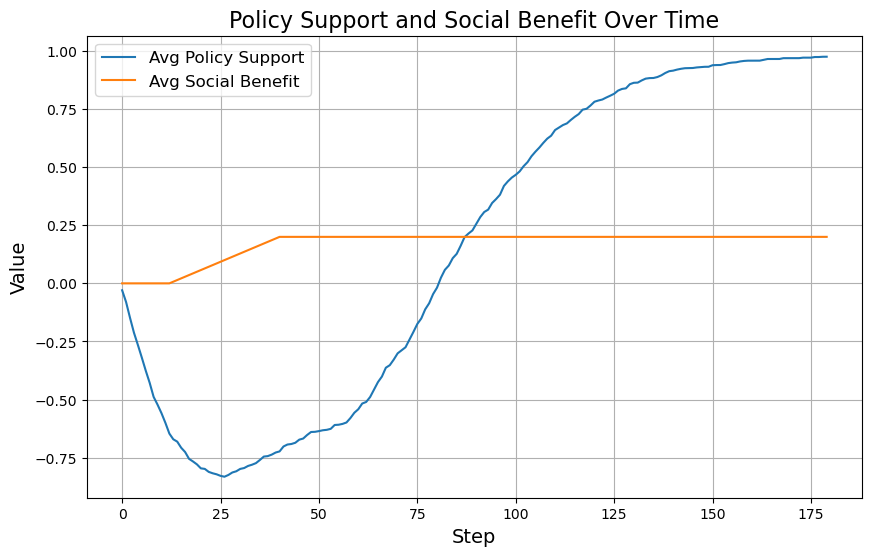

In [2]:
# Set up and run the model
my_model = PolicyModel()
#     num_agents=100,               # Number of agents in the model
#     privileged_fraction=0.3,      # Fraction of privileged nodes
#     marginalized_fraction=0.3,    # Fraction of marginalized nodes
# )

steps = 180

# Run the model for the specified number of steps
for i in range(steps):
    print(f"now running step {i}", end="\r", flush=True)
    # for n in my_model.agents:
    #   print(f"{n} opinion is {n.opinion}")
    my_model.step()

# Collect and visualize the results
data = my_model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(data["Avg Policy Support"], label="Avg Policy Support")
plt.plot(data["Avg Social Benefit"], label="Avg Social Benefit")
plt.title("Policy Support and Social Benefit Over Time", fontsize=16)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [3]:
# Count agents by category
marginalized_agents = sum(1 for agent in my_model.agents if agent.marginalized)
privileged_agents = sum(1 for agent in my_model.agents if agent.privileged)
marginalized_impacted = sum(1 for agent in my_model.agents if agent.marginalized and agent.impact != 0)
privileged_impacted = sum(1 for agent in my_model.agents if agent.privileged and agent.impact != 0)

# Print metrics
print(f"Marginalized agents: {marginalized_agents}")
print(f"Privileged agents: {privileged_agents}")
print(f"Marginalized agents impacted: {marginalized_impacted}")
print(f"Privileged agents impacted: {privileged_impacted}")

Marginalized agents: 42
Privileged agents: 14
Marginalized agents impacted: 42
Privileged agents impacted: 14


In [4]:
for a in my_model.agents:
  print(a.marginalized, a.impact, a.opinion)

False -1 0.9999999999986171
False -1 0.9999999999986171
False -1 0.9999999999986171
True 1 0.9999999999986171
False -1 0.9999999999962408
False -1 0.9999999999986171
False -1 0.9999999999986171
False -1 0.9999999999986171
False -1 0.9999999999962408
False -1 0.9999999999986171
False -1 0.9999999999986171
False -1 0.9999999999986171
False -1 0.9999999999986171
False 0 0.999999388195546
True 1 0.9999999999986171
False -1 0.9999999999986171
True 1 0.9999999999986171
False 0 0.9997532108480274
True 1 0.9999999999962408
False 0 0.9999997749296758
False 0 0.9999999172012488
True 1 0.9999999999962408
False 0 0.9999999958776926
False 0 0.9999983369439445
False 0 0.9999999984834878
False 0 0.9999665971563041
True 1 0.9999999999986171
False 0 0.9999983369439445
False 0 0.9999999887944071
False 0 0.9999999984834878
False 0 0.9999999999986171
True 1 0.9999999999986171
False -1 0.9999999999986171
False 0 0.9950547536867307
False 0 0.999999969540041
False 0 0.9950547536867307
True 1 0.99999999999861